# Get Meta Data for Tracks and Build Observed Feature Table
### To Use:
- This should all be run locally, assuming you have already downloaded the metadata SQLite DBs and put in the data folder in the the repository
    - Those can be found here:
- Run this notebook in full to create a new parquet file of items and their observed features
- Push that file to git and pull into peel
- Read that into HDFS in order to use for later scripts

### Underlying Strategy:
- The bulk of the information around tracks comes from the genres tied to the artist term
- We can treat each term as it's own binary feature
- The problem is these are not unique to artists and there are too many terms (very high d)
- We choose to only assign one term per artists, based on the overall popularity of that term
    - This way "rock" gets kept while iterations of this are often dropped
- Thus every song ends up with one associated term, which is linked through the artists
- After initial testing, we upped this to 2 terms per artist, with no improvement in performance

# Read in Data from SQLite

In [1]:
#read in packages
import sys
import os
import sqlite3
import time
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
#set file paths for dbs
data_dir = '../../data/'
    
db_file_tracks = os.path.join(data_dir, 'track_metadata.db')
db_file_artistterm = os.path.join(data_dir, 'artist_term.db')
#db_file_artistsim = os.path.join(data_dir, 'artist_similarity.db')
db_files = [db_file_tracks, db_file_artistterm]

In [3]:
# Read the songs database table into a dataframe -- with selected columns
con = sqlite3.connect(db_file_tracks)
df_songs = pd.read_sql_query("""SELECT track_id, artist_id, 
                                    duration, artist_familiarity,
                                    artist_hotttnesss, year
                               FROM songs""", con)
con.close()


print(df_songs.shape)
df_songs.head()

(1000000, 6)


,track_id,artist_id,duration,artist_familiarity,artist_hotttnesss,year
0,TRMMMYQ128F932D901,ARYZTJS1187B98C555,252.05506,0.649822,0.394032,2003
1,TRMMMKD128F425225D,ARMVN3U1187FB3A1EB,156.55138,0.439604,0.356992,1995
2,TRMMMRX128F93187D9,ARGEKB01187FB50750,138.97098,0.643681,0.437504,2006
3,TRMMMCH128F425532C,ARNWYLR1187B9B2F9C,145.05751,0.448501,0.372349,2003
4,TRMMMWA128F426B589,AREQDTE1269FB37231,514.29832,0.000000,0.000000,0


In [4]:
#read in the artist term table
con = sqlite3.connect(db_file_artistterm)

cursor = con.cursor()

#create a view that has the artist, its term and the count of that term
query_for_termcounts = """CREATE VIEW IF NOT EXISTS term_counts AS
                        SELECT 
                            t.artist_id, t.term, tc.term_count
                        FROM artist_term t,
                        (SELECT 
                                term, count(artist_id) as term_count
                            FROM artist_term
                            GROUP BY term) tc
                        WHERE tc.term = t.term"""
cursor.execute(query_for_termcounts)

#create a view with the max term count for each artist
max_term_query = """CREATE VIEW IF NOT EXISTS max_term_counts AS
                SELECT
                    artist_id,
                    max(term_count) as max_tc
                FROM term_counts
                GROUP BY 
                    artist_id"""
cursor.execute(max_term_query)

#check that this strategy doesn't drop any artists
count_check = """select count(*) from (SELECT tc.artist_id, tc.term, tc.term_count
            FROM term_counts tc, max_term_counts mtc
            WHERE
                tc.artist_id = mtc.artist_id AND
                tc.term_count = mtc.max_tc) s"""

cursor.execute(count_check)
print('artist check:',cursor.fetchone())
    
artist_count_check = "SELECT count(distinct(artist_id)) as ct FROM artist_term"
cursor.execute(artist_count_check)
print('artist check:',cursor.fetchone())

#select each artist_id and its most popular term
data_for_pandas = """SELECT tc.artist_id, tc.term
                    FROM term_counts tc, max_term_counts mtc
                    WHERE
                        tc.artist_id = mtc.artist_id AND
                        tc.term_count = mtc.max_tc"""

#write this table to pandas
df_terms = pd.read_sql_query(data_for_pandas, con)
con.close()

print('')
print(df_terms.shape)
df_terms.head()

artist check: (43943,)
artist check: (43943,)

(43943, 2)


,artist_id,term
0,AR3SC0Z1187B98C19F,00s
1,ARQ30SL1187FB596F4,70s
2,ARZBNMO1187FB4789C,70s
3,ARXJNYS1269FB3390C,8-bit
4,ARYXCYV1269FCCE983,8-bit


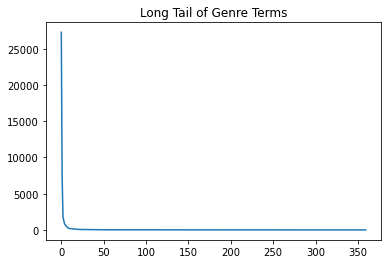

,artist_id
term,
rock,27274
electronic,7234
pop,1824
hip hop,1242
jazz,799
united states,686
folk,469
alternative rock,405
house,258


In [5]:
#plotting the long tail of terms
terms = df_terms.groupby('term').count().sort_values(by=['artist_id'], ascending=False)
plt.title('Long Tail of Genre Terms')
plt.plot(terms.artist_id.to_numpy())
plt.show()

terms.head(10)

# Data cleaning in dataframes

In [6]:
#multi-hot encoding for the terms (was more nuanced when we had multiple terms per artist)

#aggregate all the terms into a single list for each term
df_terms = df_terms.groupby('artist_id')['term'].apply(list).reset_index().set_index('artist_id')
df_terms = df_terms.rename(columns={"term": "term_list"})

#get counts for each term (will be binary)
df_terms_counter = df_terms['term_list'].apply(Counter)

In [7]:
#turn this into a "mutli-hot encoded" dataframe
df_terms_bin = pd.DataFrame.from_records(df_terms_counter).fillna(value=0)

#then add the artist_id and set the as the index
df_terms_bin['artist_id'] = df_terms.index
df_terms_bin = df_terms_bin.set_index('artist_id')

In [8]:
df_terms_bin.head()

,rock,electronic,hip hop,alternative rock,united states,pop,chill-out,american,los angeles,jazz,...,noise rock,brazil,gospel,folklore,baroque,soft rock,space rock,metalcore,thrash metal,euro-trance
artist_id,,,,,,,,,,,,,,,,,,,,,
AR002UA1187B9A637D,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR003FB1187B994355,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR006821187FB5192B,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR009211187B989185,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR009SZ1187B9A73F4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Joining into one table

In [9]:
#join the artist table with the terms table
    #drop the artist table as it's not a feature
    #drop the last feature to avoid colinearities
df_joined = df_songs.join(df_terms_bin, on='artist_id')
df_joined = df_joined.drop(columns=['artist_id','euro-trance'])

In [10]:
df_joined

,track_id,duration,artist_familiarity,artist_hotttnesss,year,rock,electronic,hip hop,alternative rock,united states,...,horrorcore,noise rock,brazil,gospel,folklore,baroque,soft rock,space rock,metalcore,thrash metal
0,TRMMMYQ128F932D901,252.05506,0.649822,0.394032,2003,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRMMMKD128F425225D,156.55138,0.439604,0.356992,1995,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRMMMRX128F93187D9,138.97098,0.643681,0.437504,2006,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRMMMCH128F425532C,145.05751,0.448501,0.372349,2003,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRMMMWA128F426B589,514.29832,0.000000,0.000000,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRYYYUS12903CD2DF0,217.44281,0.528617,0.411595,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999996,TRYYYJO128F426DA37,244.16608,0.401500,0.374866,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999997,TRYYYMG128F4260ECA,553.03791,0.556918,0.336914,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999998,TRYYYDJ128F9310A21,484.51873,0.403668,0.256935,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Check for Nulls

In [11]:
#check for an index of a null value
df_joined.baroque.isnull().argmax()

#get the track id associated to these nulls
track_id_to_chcek = df_joined.iloc[50].track_id

#get the artist_id causing nulls
artist_id_to_check = df_songs.loc[df_songs.track_id == track_id_to_chcek].artist_id.values[0]

artist_id_to_check

'ARCIVXI127BF5F1610'

In [12]:
# Read the songs database table into a dataframe -- with selected columns
con = sqlite3.connect(db_file_artistterm)
check = pd.read_sql_query("""SELECT *
                               FROM artist_term
                               WHERE artist_id = 'ARCIVXI127BF5F1610'""", con)
con.close()


print('Number of records with artist ARCIVXI127BF5F1610 in artist_term table:',check.shape[0])


con = sqlite3.connect(db_file_tracks)
check = pd.read_sql_query("""SELECT *
                               FROM songs
                               WHERE artist_id = 'ARCIVXI127BF5F1610'""", con)
con.close()


print('Number of records with artist ARCIVXI127BF5F1610 in songs table:',check.shape[0])

Number of records with artist ARCIVXI127BF5F1610 in artist_term table: 0
Number of records with artist ARCIVXI127BF5F1610 in songs table: 50


# Writing out to Parquet

In [13]:
df_joined.to_parquet('items_meta_new.parquet')

# Updating Meta Feature Table
Due to poor performance of the cold start model using the above features, we decided to expand out our feature space. To do this we chose the top 2 most popular terms associated with each artist to map those back to each track id

In [14]:
#query ranks the term count scores by for each artist and selects top 2
query = """SELECT artist_id, term 
        FROM 
            (SELECT
                at.artist_id,
                at.term,
                tc.term_count,
                RANK () OVER (
                    PARTITION BY at.artist_id
                    ORDER BY term_count DESC
                ) as rank
            FROM
            artist_term at,
            (SELECT
                term,
                count(artist_id) as term_count
            FROM artist_term
            GROUP BY 
                term) tc
            WHERE tc.term = at.term) subt
        WHERE rank <= 2
        """

con = sqlite3.connect(db_file_artistterm)
df_terms_updated = pd.read_sql_query(query, con)
con.close()

print(df_terms_updated.shape)
df_terms_updated.head()

(87100, 2)


,artist_id,term
0,AR002UA1187B9A637D,rock
1,AR002UA1187B9A637D,electronic
2,AR003FB1187B994355,rock
3,AR003FB1187B994355,alternative rock
4,AR006821187FB5192B,rock


In [15]:
#multi-hot encoding for the terms (was more nuanced when we had multiple terms per artist)

#aggregate all the terms into a single list for each term
df_terms_updated = df_terms_updated.groupby('artist_id')['term'].apply(list).reset_index().set_index('artist_id')
df_terms_updated = df_terms_updated.rename(columns={"term": "term_list"})

#get counts for each term (will be binary)
df_terms_counter = df_terms_updated['term_list'].apply(Counter)

In [16]:
#turn this into a "mutli-hot encoded" dataframe
df_terms_bin_update = pd.DataFrame.from_records(df_terms_counter).fillna(value=0)

#then add the artist_id and set the as the index
df_terms_bin_update['artist_id'] = df_terms_updated.index
df_terms_bin_update = df_terms_bin_update.set_index('artist_id')

In [17]:
df_terms_bin_update.head()

,rock,electronic,alternative rock,pop,united states,house,hip hop,rap,experimental,electro,...,jam,folklore,greek music,experimental pop,techstep,belgium,psychedelic pop,soft rock,space rock,college rock
artist_id,,,,,,,,,,,,,,,,,,,,,
AR002UA1187B9A637D,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR003FB1187B994355,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR006821187FB5192B,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR009211187B989185,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR009SZ1187B9A73F4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#join the artist table with the terms table
    #drop the artist table as it's not a feature
    #drop the last feature to avoid colinearities
df_joined_update = df_songs.join(df_terms_bin_update, on='artist_id')
df_joined_update = df_joined_update.drop(columns=['artist_id','college rock'])

In [19]:
df_joined_update

,track_id,duration,artist_familiarity,artist_hotttnesss,year,rock,electronic,alternative rock,pop,united states,...,clarinet,jam,folklore,greek music,experimental pop,techstep,belgium,psychedelic pop,soft rock,space rock
0,TRMMMYQ128F932D901,252.05506,0.649822,0.394032,2003,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRMMMKD128F425225D,156.55138,0.439604,0.356992,1995,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRMMMRX128F93187D9,138.97098,0.643681,0.437504,2006,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRMMMCH128F425532C,145.05751,0.448501,0.372349,2003,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRMMMWA128F426B589,514.29832,0.000000,0.000000,0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRYYYUS12903CD2DF0,217.44281,0.528617,0.411595,0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999996,TRYYYJO128F426DA37,244.16608,0.401500,0.374866,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999997,TRYYYMG128F4260ECA,553.03791,0.556918,0.336914,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999998,TRYYYDJ128F9310A21,484.51873,0.403668,0.256935,0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_joined_update.to_parquet('items_meta_updated.parquet')